# Regression training on Gamma+Proton and testing on Proton

Notebook where in the fits also proton showers are included

In [1]:
# Importing some libraries

# Torch 
import torch
from torch import nn
import torch.nn.functional as F
from torchview import draw_graph

# Other libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import jaccard_score

**Unpacking the data**

In this first part, some functions are defined to unpack the data.

In [43]:
class CPU_Unpickler(pickle.Unpickler):
    # to avoid errors that occur when loading pickle files on cpu that were originally saved using a gpu
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [44]:
# Function that enables you to unpack a certain chunk of data
def load_chunk_file(file_path, chunk_i):
    with open(file_path+f'chunk_{chunk_i}', 'rb') as file:
            loaded_data = CPU_Unpickler(file).load()
            
    return loaded_data

In [45]:
# The locations of the data
file_path_noisy = '/lustre/fs23/group/cta/users/amehta/summer_student_data/noisy_images/'
file_path_true = '/lustre/fs23/group/cta/users/amehta/summer_student_data/true_images/'

# Unpack 100 chunks of data
chunk_tot = 100

data_noisy_tot = np.array([])
data_true_tot = np.array([])
data_target_tot = np.array([])

for chunk_i in range(0,chunk_tot):
    data_noisy_all = load_chunk_file(file_path_noisy, chunk_i)
    data_noisy_chunk = np.array(data_noisy_all[0])
    data_noisy_tot = np.append(data_noisy_tot, data_noisy_chunk)
    
    data_true_all = load_chunk_file(file_path_true, chunk_i)
    data_true_chunk = np.array(data_true_all[0])
    data_true_tot = np.append(data_true_tot, data_true_chunk)
    
    data_target_chunk = np.array(data_noisy_all[1])
    data_target_tot = np.append(data_target_tot, data_target_chunk)
    
    
# Get it in the right shape
data_noisy = data_noisy_tot.reshape(128*chunk_tot, 56, 56)
data_true = data_true_tot.reshape(128*chunk_tot, 56, 56)
data_target = data_target_tot.reshape(128*chunk_tot)

**Training: Gamma+Proton --> Testing: Gamma**

In [46]:
# Now with a minimum of 0

nan_mask = np.isnan(data_noisy[0])
data_noisy_nonan = np.nan_to_num(data_noisy)
data_true_nonan = np.nan_to_num(data_true)

# Look at the sum of all the pixels for the noisy and true images

images_noisy_sum = np.nansum(data_noisy, axis=(1,2))
images_true_sum = np.nansum(data_true, axis=(1,2))

images_high_mask = (images_noisy_sum>60)

# Look at the true images only with pixels of 0 and 1 (non-signal and signal)
# For the purpose of the classification

threshold = 0

data_true_nonan_flat = data_true_nonan.reshape((128*chunk_tot, 56*56))

# Putting them to the right form with normalization
data_noisy_arr = data_noisy[images_high_mask]
data_noisy_arr[np.nan_to_num(data_noisy_arr)<0] = 0

pix_max_noisy = np.nanmax(data_noisy_arr, axis=(1,2))[:, np.newaxis, np.newaxis]
data_noisy_norm = np.nan_to_num(data_noisy_arr/pix_max_noisy)
data_noisy_tensor = (torch.from_numpy(data_noisy_norm).float())


# Now normalize the true data in the same way as the noisy data

data_true_arr = data_true_nonan_flat[images_high_mask]
pix_max_true = np.nanmax(data_noisy_arr, axis=(1,2))[:, np.newaxis]
data_true_norm = np.nan_to_num(data_true_arr/pix_max_true)
data_true_tensor = (torch.from_numpy(data_true_norm).float())

data_noisy_tensor_im = (torch.from_numpy(data_noisy[images_high_mask])).float()

data_true_tensor_im = (torch.from_numpy(data_true[images_high_mask])).float()

# Split train and test

N, w, h = data_noisy_tensor.shape
idx_split = int(N*0.8) # 80% training, 20% testing
data_target_train = (data_target[images_high_mask])[:idx_split]
data_target_test = (data_target)[images_high_mask][idx_split:]
data_noisy_train = data_noisy_tensor[:idx_split]
data_true_train = data_true_tensor[:idx_split]
data_noisy_test = (data_noisy_tensor[idx_split:])[data_target_test==1]
data_true_test = (data_true_tensor[idx_split:])[data_target_test==1]

data_noisy_train_im = data_noisy_tensor_im[:idx_split]
data_true_train_im = data_true_tensor_im[:idx_split]
data_noisy_test_im = (data_noisy_tensor_im[idx_split:])[data_target_test==1]
data_true_test_im = (data_true_tensor_im[idx_split:])[data_target_test==1]



**AE Model**

In [47]:
# AE with 4 layers

class AE4(nn.Module):
    def __init__(self):
        super().__init__()
        
        second_layer = 75
            
        # Encoder functions
        self.conv1a = nn.Conv2d(1, 10, kernel_size=(3,3), padding='same')
        self.conv1b = nn.Conv2d(10, 10, kernel_size=(3,3), padding='same')
        self.conv2a = nn.Conv2d(10, second_layer, kernel_size=(3,3), padding='same')
        self.conv2b = nn.Conv2d(second_layer, second_layer, kernel_size=(3,3), padding='same')
        
        # Decoder functions
        self.deconv1a = nn.ConvTranspose2d(second_layer, second_layer, kernel_size=(3,3), padding=1)
        self.deconv1b = nn.ConvTranspose2d(second_layer, 10, kernel_size=(3,3), padding=1)
        self.deconv2a = nn.ConvTranspose2d(10, 10, kernel_size=(3,3), padding=1)
        self.deconv2b = nn.ConvTranspose2d(10, 1, kernel_size=(3,3), padding=1)
        
    def forward(self, x):
        if x.dim() == 3:  # (C, H, W)
            x = x.unsqueeze(0)  # Convert to (N, C, H, W)
            
        N = (x.shape)[0]
        
        # Encoder part
        x = F.relu(self.conv1a(x))
        x = self.conv1b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        x = F.relu(self.conv2a(x))
        x = self.conv2b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        
        # Decoder part
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv1a(x))
        x = F.relu(self.deconv1b(x))
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv2a(x))
        x = self.deconv2b(x)
        
        # Get the right shape
        x = x.squeeze(0)
        
        if N==1:
            x = x.reshape(1, 56*56)
        else:
            x = x.reshape(batch_size, 56*56)
        
        return x         

**Fitting functions**

In [48]:
# Functions and definitions for 
n_epochs = 3

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

batch_size=1
weight = 2

# This is the main training loop
def train(epoch):
    network.train()
    
    i=0
    train_loss = 0
    
    random_indices = torch.randperm(len(data_noisy_train))
    data_noisy_train_clone = torch.clone(data_noisy_train)
    data_true_train_clone = torch.clone(data_true_train)
    
    data_noisy_train[random_indices] = data_noisy_train_clone
    data_true_train[random_indices] = data_true_train_clone
    
    for noisy, true in zip(data_noisy_train, data_true_train):
        noisy = noisy.unsqueeze(0)
        true = true.unsqueeze(0)
        
        i=i+1
        optimizer.zero_grad()
        output = network(noisy)
        weights = torch.tensor([weight])
        loss = F.mse_loss(output, true)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*batch_size
    train_losses.append(train_loss/len(data_noisy_train))
    print('Training set: Avg. loss: {:.6f}'.format(train_loss/len(data_noisy_train)))

# This is the main testing loop
def test():
    network.eval()
    IOU = 0
    test_loss = 0
    correct = 0
    i=0
    with torch.no_grad():
        for noisy, true in zip(data_noisy_test, data_true_test):
            noisy = noisy.unsqueeze(0)
            true = true.unsqueeze(0)
            
            i=i+1
            output = network(noisy)
            weights = torch.tensor([weight])
            loss = F.mse_loss(output, true)
            test_loss += loss.item()
    
    test_loss /= len(data_noisy_test)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.6f}'.format(test_loss))

In [49]:
%%time

n_epochs = 20

learning_rate = 0.0001

network = AE4()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test set: Avg. loss: 0.029141
Training set: Avg. loss: 0.000527

Test set: Avg. loss: 0.000267
Training set: Avg. loss: 0.000329

Test set: Avg. loss: 0.000221
Training set: Avg. loss: 0.000294

Test set: Avg. loss: 0.000207
Training set: Avg. loss: 0.000273

Test set: Avg. loss: 0.000190
Training set: Avg. loss: 0.000259

Test set: Avg. loss: 0.000185
Training set: Avg. loss: 0.000250

Test set: Avg. loss: 0.000180
Training set: Avg. loss: 0.000241

Test set: Avg. loss: 0.000176
Training set: Avg. loss: 0.000234

Test set: Avg. loss: 0.000169
Training set: Avg. loss: 0.000228

Test set: Avg. loss: 0.000170
Training set: Avg. loss: 0.000223

Test set: Avg. loss: 0.000186
Training set: Avg. loss: 0.000219

Test set: Avg. loss: 0.000166
Training set: Avg. loss: 0.000215

Test set: Avg. loss: 0.000168
Training set: Avg. loss: 0.000212

Test set: Avg. loss: 0.000164
Training set: Avg. loss: 0.000209

Test set: Avg. loss: 0.000162
Training set: Avg. loss: 0.000206

Test set: Avg. loss: 0.0

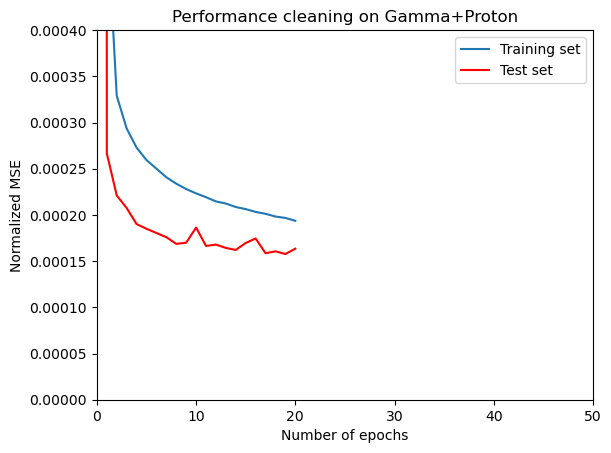

In [50]:
plt.figure()
plt.title("Performance cleaning on Gamma+Proton")
plt.plot(train_counter, train_losses, label='Training set')
plt.plot(test_counter, test_losses, color='red', label='Test set')
plt.ylim(0,0.0004)
plt.xlim(0,50)
plt.xlabel("Number of epochs")
plt.ylabel("Normalized MSE")
plt.legend()
plt.show()

**Comparing gamma+proton training with gamma training**

In [31]:
train_losses_g_g = np.array([0.0005581689555176889, 0.0003001426026288143, 0.0002545075019465605, 0.00022916833172762069, 0.00021361903417396874, 0.00020224507533008813, 0.00019485515232936095, 0.00018884437114753395, 0.0001838211523828295, 0.00017856507856136422, 0.00017462354810961206, 0.0001708120671882333, 0.00016735952323079624, 0.0001643707516870944, 0.00016120966302734244, 0.00015839704884526289, 0.0001560649073262741, 0.00015346468983541944, 0.00015119534347341526, 0.00014816383526117607, 0.0001468664516607209, 0.00014425724372138185, 0.00014232536894033393, 0.00014065101682856149, 0.00013971748006328096, 0.0001372409402840308, 0.0001353792969720883, 0.00013306375667497005, 0.00013198101189505358, 0.00013032814519729045, 0.00012878149648176706, 0.0001270469376303399, 0.00012580470004860101, 0.00012411478262595432, 0.00012286741629686886, 0.000121517963496641, 0.00012053352042922587, 0.00011920015326960663, 0.00011781592736195761, 0.00011657202193671347, 0.00011559115878930618, 0.00011499340931966124, 0.00011419860318117564, 0.00011189394317152137, 0.00011150612428128052, 0.00011055193284214432, 0.00010945724450924008, 0.00010905958988732254, 0.00010774922256884782, 0.00010710001036710781])
test_losses_g_g = np.array([0.019317077325799004, 0.0003006815523049594, 0.00025663429227393465, 0.00022527160997378, 0.0002102763772950413, 0.00020111100535857154, 0.0001993169493640062, 0.00018903599868093552, 0.00018316151710245926, 0.00017821530236361701, 0.00018076673495017996, 0.00017326594424590814, 0.0001760860770531663, 0.0001723708792028834, 0.00017001701442601727, 0.00016847836035056456, 0.0001681853437726673, 0.0001696965230042432, 0.0001674975749322874, 0.00016726778681840445, 0.0001666130233596686, 0.00016459943383130844, 0.00016690974796989647, 0.00016723738300108396, 0.0001669554924215527, 0.00017125633466881, 0.00016879327338454605, 0.0001711363618702846, 0.00016638965445653586, 0.00016959621938595232, 0.00016658355687696822, 0.0001724441230033849, 0.0001696075094836724, 0.00017023935037829155, 0.00017170167178797954, 0.00017177281016248985, 0.000169694742485242, 0.00017120075362737173, 0.00017258521305962458, 0.00017200614420615916, 0.00017726565007544987, 0.00017276223782700085, 0.00017323377823610863, 0.00018282335581818287, 0.00017392121089176423, 0.00017273913456565955, 0.00017714873464328652, 0.0001716697043386147, 0.0001784579357091988, 0.0001749353309773011, 0.00017478827400692055])

train_losses_gamma = np.array([0.0005581689555176889, 0.0003001426026288143, 0.0002545075019465605, 0.00022916833172762069, 0.00021361903417396874, 0.00020224507533008813, 0.00019485515232936095, 0.00018884437114753395, 0.0001838211523828295, 0.00017856507856136422, 0.00017462354810961206, 0.0001708120671882333, 0.00016735952323079624, 0.0001643707516870944, 0.00016120966302734244, 0.00015839704884526289, 0.0001560649073262741, 0.00015346468983541944, 0.00015119534347341526, 0.00014816383526117607, 0.0001468664516607209, 0.00014425724372138185, 0.00014232536894033393, 0.00014065101682856149, 0.00013971748006328096, 0.0001372409402840308, 0.0001353792969720883, 0.00013306375667497005, 0.00013198101189505358, 0.00013032814519729045, 0.00012878149648176706, 0.0001270469376303399, 0.00012580470004860101, 0.00012411478262595432, 0.00012286741629686886, 0.000121517963496641, 0.00012053352042922587, 0.00011920015326960663, 0.00011781592736195761, 0.00011657202193671347, 0.00011559115878930618, 0.00011499340931966124, 0.00011419860318117564, 0.00011189394317152137, 0.00011150612428128052, 0.00011055193284214432, 0.00010945724450924008, 0.00010905958988732254, 0.00010774922256884782, 0.00010710001036710781])
test_losses_gamma = np.array([0.019317077325799004, 0.0003006815523049594, 0.00025663429227393465, 0.00022527160997378, 0.0002102763772950413, 0.00020111100535857154, 0.0001993169493640062, 0.00018903599868093552, 0.00018316151710245926, 0.00017821530236361701, 0.00018076673495017996, 0.00017326594424590814, 0.0001760860770531663, 0.0001723708792028834, 0.00017001701442601727, 0.00016847836035056456, 0.0001681853437726673, 0.0001696965230042432, 0.0001674975749322874, 0.00016726778681840445, 0.0001666130233596686, 0.00016459943383130844, 0.00016690974796989647, 0.00016723738300108396, 0.0001669554924215527, 0.00017125633466881, 0.00016879327338454605, 0.0001711363618702846, 0.00016638965445653586, 0.00016959621938595232, 0.00016658355687696822, 0.0001724441230033849, 0.0001696075094836724, 0.00017023935037829155, 0.00017170167178797954, 0.00017177281016248985, 0.000169694742485242, 0.00017120075362737173, 0.00017258521305962458, 0.00017200614420615916, 0.00017726565007544987, 0.00017276223782700085, 0.00017323377823610863, 0.00018282335581818287, 0.00017392121089176423, 0.00017273913456565955, 0.00017714873464328652, 0.0001716697043386147, 0.0001784579357091988, 0.0001749353309773011, 0.00017478827400692055])



In [32]:
print(test_losses)
print(train_losses)

[0.04647187660819134, 0.00027147580274090735, 0.00022363108544161262, 0.0002021821362282066, 0.0001889043361132329, 0.00018733030625475922, 0.0001793782107315806, 0.00017601624066733207, 0.00017092005512825227, 0.00017063672601588088, 0.00016892512536102421, 0.00016543978119314858, 0.0001705822433060163, 0.00018155159827541205, 0.0001671078056798871, 0.00016230480762602478, 0.00016429128380942345, 0.00016280148094013552, 0.00016397519910451672, 0.00016962367591415097, 0.00017479580018138287, 0.00017690491596652393, 0.00015935414367291274, 0.00016571435759612694, 0.0001642350495624677, 0.00016318753932864638, 0.00016313585880012814, 0.0001640631590696336, 0.00016881559076703534, 0.00015922823096272334, 0.00015925307496950436, 0.0001659441517291367, 0.00016099522532562961, 0.00016645430192889697, 0.00016626099691528207, 0.0001634957898518344, 0.00016634062322229946, 0.00016418459117590602, 0.00016922198441276864, 0.0001624803452493558, 0.0001643490027107012, 0.00018123770854461615, 0.000

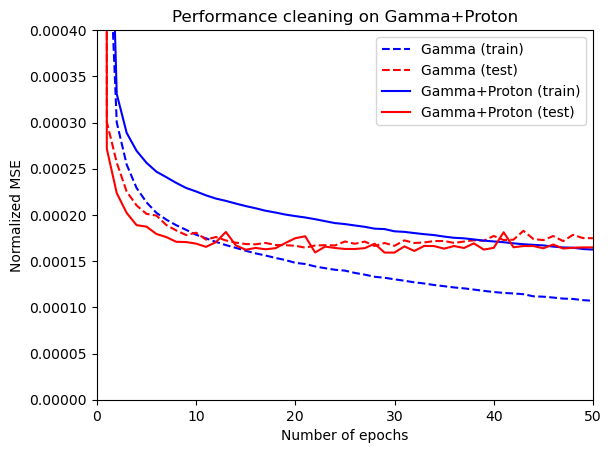

In [33]:
plt.figure()
plt.title("Performance cleaning on Gamma+Proton")
plt.plot(train_counter, train_losses_gamma, color='blue', linestyle='--', label='Gamma (train)')
plt.plot(test_counter, test_losses_gamma, color='red', linestyle='--', label='Gamma (test)')
plt.plot(train_counter, train_losses, color='blue', label='Gamma+Proton (train)')
plt.plot(test_counter, test_losses, color='red', label='Gamma+Proton (test)')
plt.ylim(0,0.0004)
plt.xlim(0,50)
plt.xlabel("Number of epochs")
plt.ylabel("Normalized MSE")
plt.legend()
plt.show()

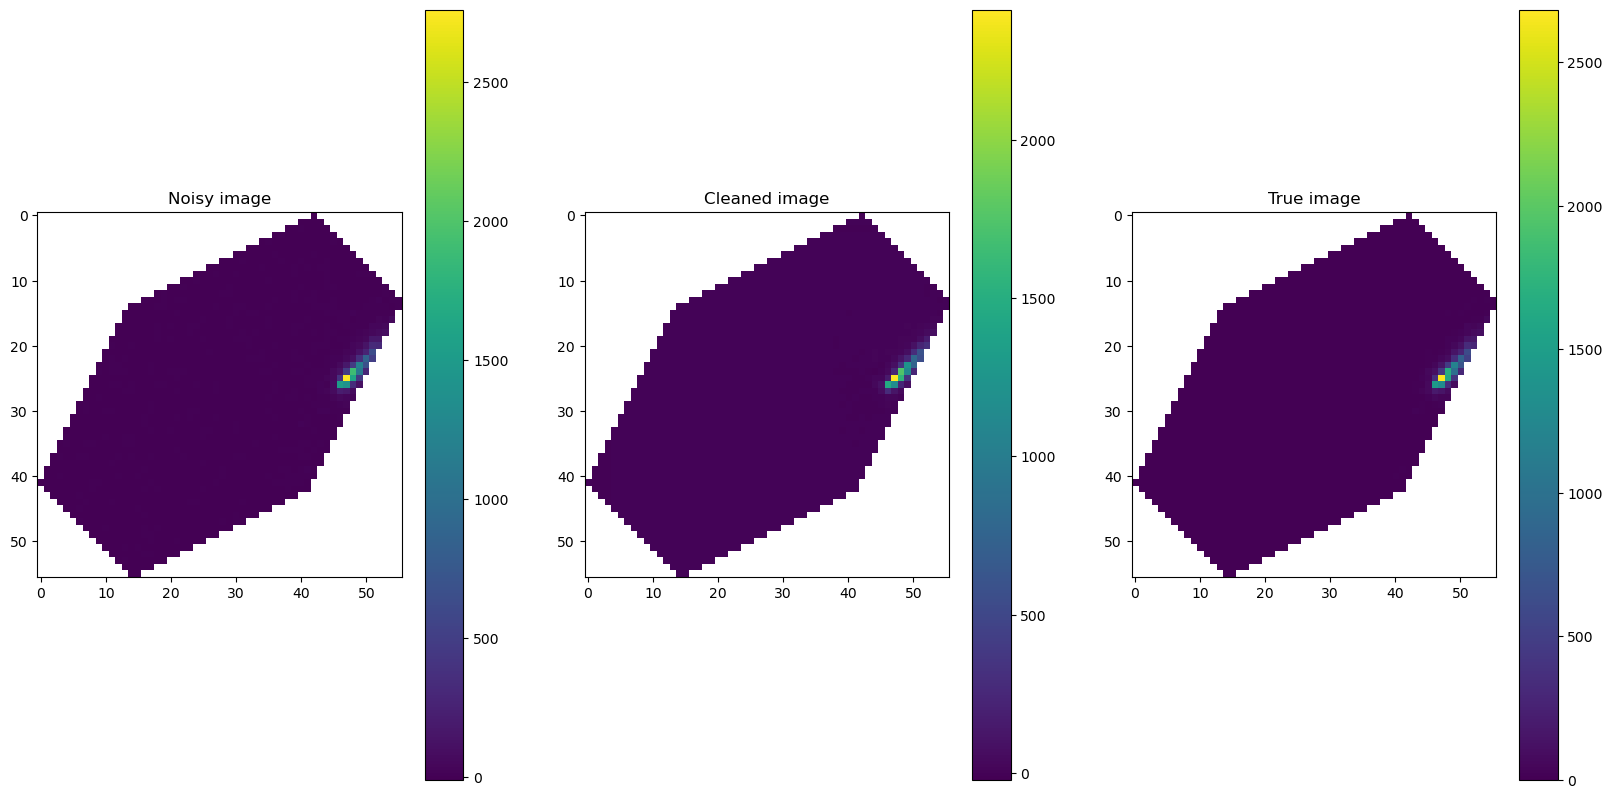

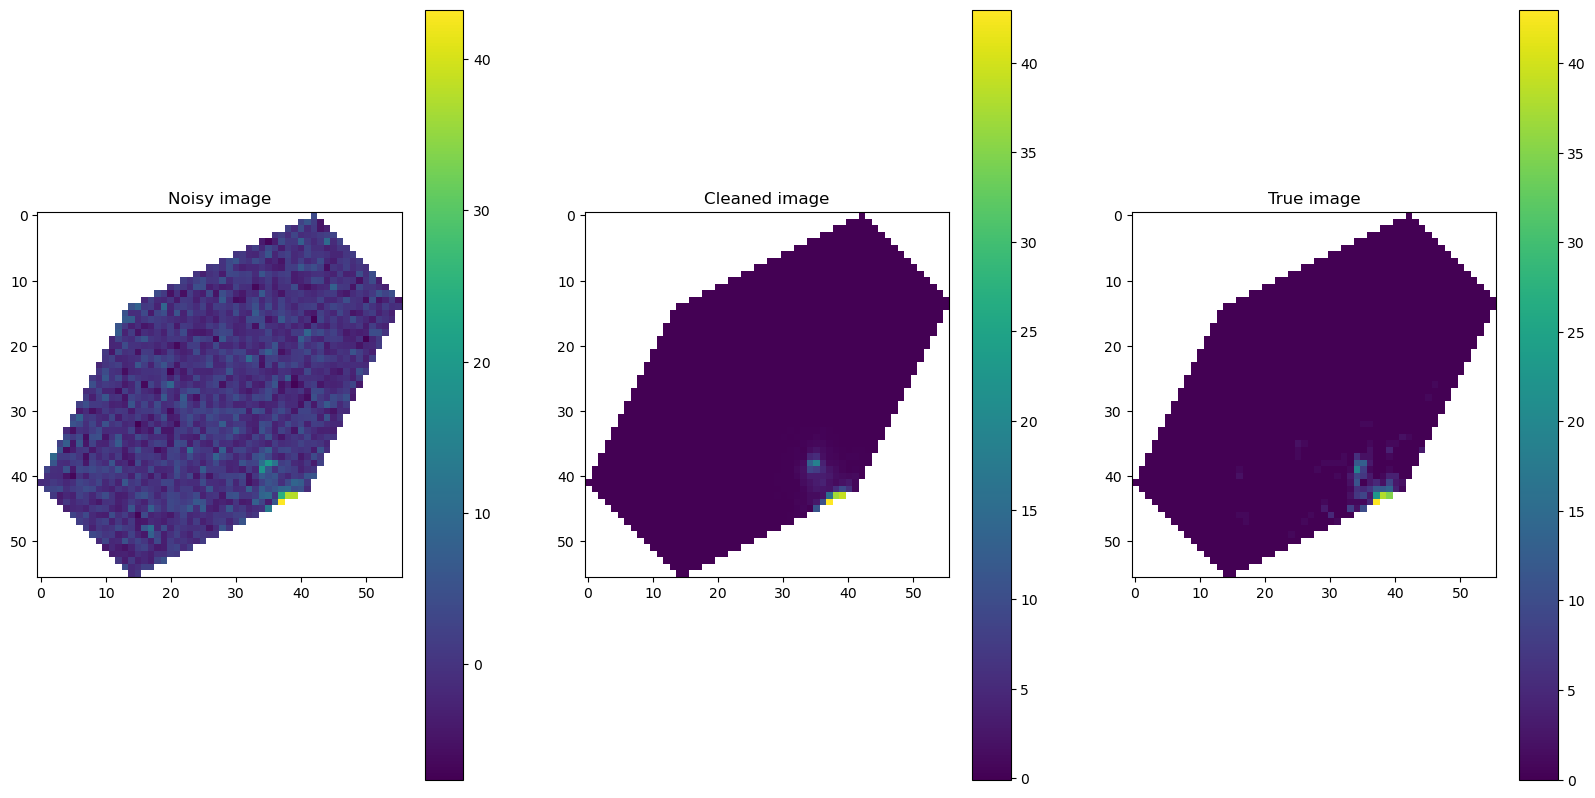

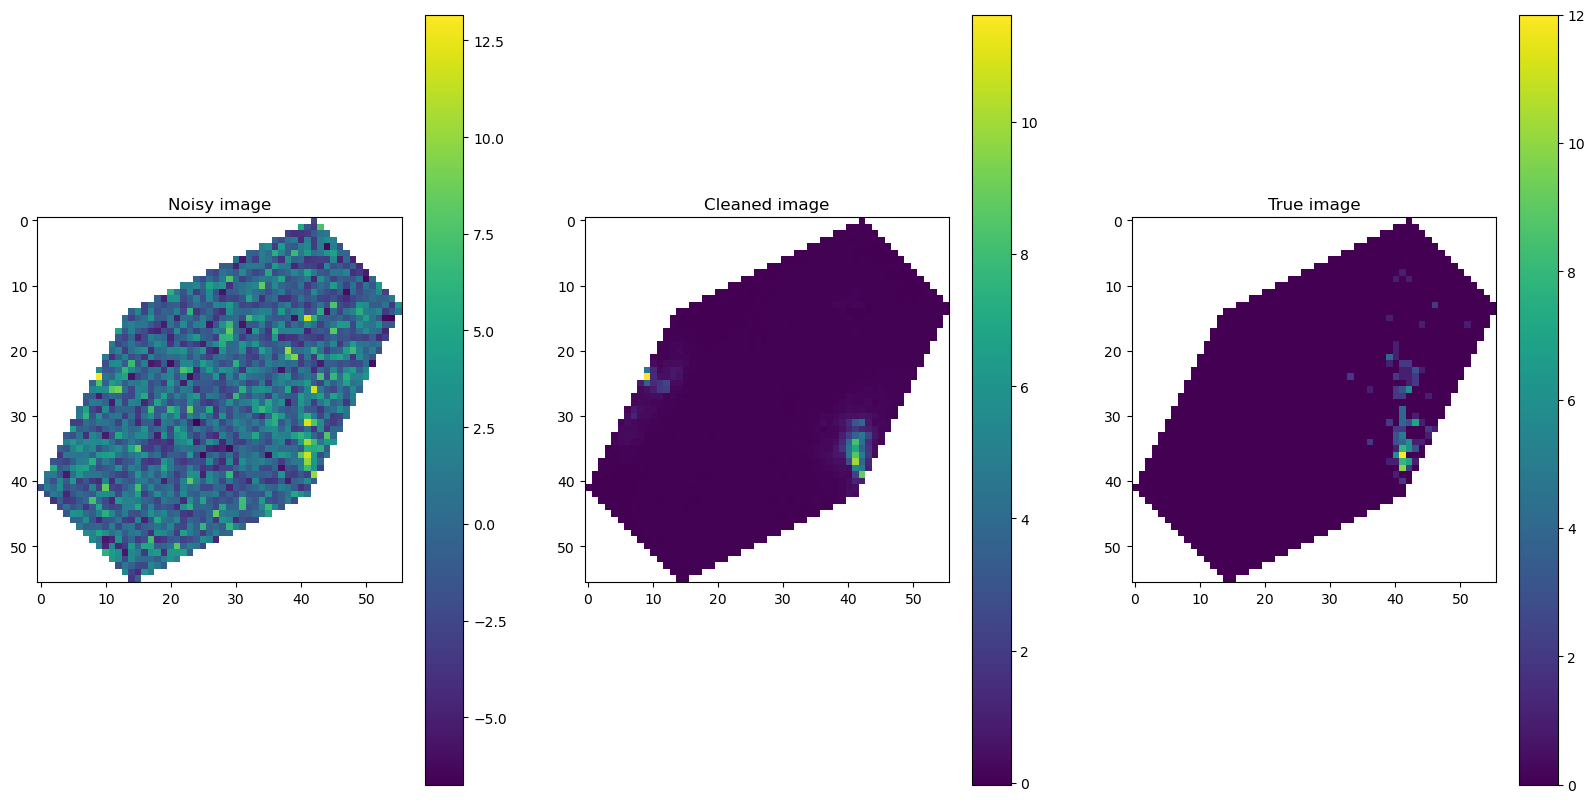

In [34]:
n_start = 3
n_im = 3

for im_i in range(n_start, n_start+n_im):
    output = network(data_noisy_test[im_i].unsqueeze(0))


    im_clean = (output.data).reshape(56, 56)
    
    #im_clean = im_clean*(pix_max_noisy[idx_split+im_i][0][0]-pix_min_noisy[idx_split+im_i][0][0]) + pix_min_noisy[idx_split+im_i][0][0]
    im_clean = im_clean*pix_max_noisy[idx_split+im_i][0][0]
    #im_clean = im_clean_prob.round()
    #mask_clean = im_clean.astype(bool)
    #im_clean_good = np.zeros((56,56))

    #im_clean_good[mask_clean] = data_noisy_test_im[im_i][mask_clean]
    im_clean[nan_mask] = np.nan
    
    fig, axs = plt.subplots(1,3,figsize=(20,10))

    fig_noisy = axs[0].imshow(data_noisy_test_im[im_i])#, vmin=0)
    axs[0].set_title("Noisy image")
    fig.colorbar(fig_noisy, ax=axs[0])

    fig_clean = axs[1].imshow(im_clean.detach().numpy())#, vmin=0)
    axs[1].set_title("Cleaned image")
    fig.colorbar(fig_clean, ax=axs[1])

    fig_true = axs[2].imshow(data_true_test_im[im_i])#, vmin=0)
    axs[2].set_title("True image")
    fig.colorbar(fig_true, ax=axs[2])

plt.show()    

**Training: Gamma --> Testing: Proton**

In [35]:
# Now with a minimum of 0

nan_mask = np.isnan(data_noisy[0])
data_noisy_nonan = np.nan_to_num(data_noisy)
data_true_nonan = np.nan_to_num(data_true)

# Look at the sum of all the pixels for the noisy and true images

images_noisy_sum = np.nansum(data_noisy, axis=(1,2))
images_true_sum = np.nansum(data_true, axis=(1,2))

images_high_mask = (images_noisy_sum>60)

# Look at the true images only with pixels of 0 and 1 (non-signal and signal)
# For the purpose of the classification

threshold = 0

data_true_nonan_flat = data_true_nonan.reshape((128*chunk_tot, 56*56))

# Putting them to the right form with normalization
data_noisy_arr = data_noisy[images_high_mask]
data_noisy_arr[np.nan_to_num(data_noisy_arr)<0] = 0

pix_max_noisy = np.nanmax(data_noisy_arr, axis=(1,2))[:, np.newaxis, np.newaxis]
data_noisy_norm = np.nan_to_num(data_noisy_arr/pix_max_noisy)
data_noisy_tensor = (torch.from_numpy(data_noisy_norm).float())


# Now normalize the true data in the same way as the noisy data

data_true_arr = data_true_nonan_flat[images_high_mask]
pix_max_true = np.nanmax(data_noisy_arr, axis=(1,2))[:, np.newaxis]
data_true_norm = np.nan_to_num(data_true_arr/pix_max_true)
data_true_tensor = (torch.from_numpy(data_true_norm).float())

data_noisy_tensor_im = (torch.from_numpy(data_noisy[images_high_mask])).float()

data_true_tensor_im = (torch.from_numpy(data_true[images_high_mask])).float()

# Split train and test

N, w, h = data_noisy_tensor.shape
idx_split = int(N*0.8) # 80% training, 20% testing
data_target_train = (data_target[images_high_mask])[:idx_split]
data_target_test = (data_target)[images_high_mask][idx_split:]
data_noisy_train = data_noisy_tensor[:idx_split][data_target_train==1]
data_true_train = data_true_tensor[:idx_split][data_target_train==1]
data_noisy_test = (data_noisy_tensor[idx_split:])[data_target_test==0]
data_true_test = (data_true_tensor[idx_split:])[data_target_test==0]

data_noisy_train_im = data_noisy_tensor_im[:idx_split][data_target_train==1]
data_true_train_im = data_true_tensor_im[:idx_split][data_target_train==1]
data_noisy_test_im = (data_noisy_tensor_im[idx_split:])[data_target_test==0]
data_true_test_im = (data_true_tensor_im[idx_split:])[data_target_test==0]



In [36]:
%%time

n_epochs = 50

learning_rate = 0.0001

network = AE4()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test set: Avg. loss: 0.010687
Training set: Avg. loss: 0.000515

Test set: Avg. loss: 0.000471
Training set: Avg. loss: 0.000291

Test set: Avg. loss: 0.000464
Training set: Avg. loss: 0.000251

Test set: Avg. loss: 0.000386
Training set: Avg. loss: 0.000231

Test set: Avg. loss: 0.000369
Training set: Avg. loss: 0.000217

Test set: Avg. loss: 0.000363
Training set: Avg. loss: 0.000208

Test set: Avg. loss: 0.000343
Training set: Avg. loss: 0.000200

Test set: Avg. loss: 0.000347
Training set: Avg. loss: 0.000194

Test set: Avg. loss: 0.000358
Training set: Avg. loss: 0.000189

Test set: Avg. loss: 0.000334
Training set: Avg. loss: 0.000184

Test set: Avg. loss: 0.000328
Training set: Avg. loss: 0.000179

Test set: Avg. loss: 0.000324
Training set: Avg. loss: 0.000176

Test set: Avg. loss: 0.000323
Training set: Avg. loss: 0.000172

Test set: Avg. loss: 0.000323
Training set: Avg. loss: 0.000168

Test set: Avg. loss: 0.000333
Training set: Avg. loss: 0.000165

Test set: Avg. loss: 0.0

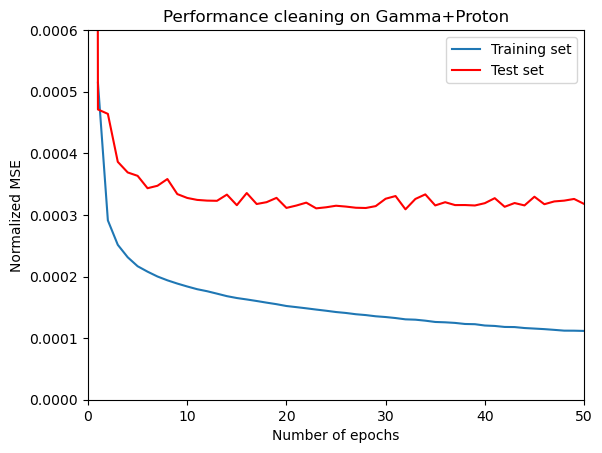

[0.0005145692834399062, 0.00029112847628195304, 0.00025149560095243936, 0.0002312658856540215, 0.0002167039690088957, 0.00020788225379200315, 0.00020003496973565907, 0.00019384118018984584, 0.00018855926728007913, 0.000183814480427801, 0.00017942505416571362, 0.00017614541452292296, 0.0001721921090785861, 0.0001681277663825306, 0.00016508700017353205, 0.0001627712840949168, 0.0001602622362701366, 0.00015760015443052873, 0.00015509170178516242, 0.0001521314371586945, 0.00015030405847518065, 0.00014839746558783004, 0.0001463566608285859, 0.00014445287401432954, 0.00014235591739453812, 0.0001408272176517116, 0.0001387784013369922, 0.00013740396832638004, 0.00013545401318720273, 0.00013423161351843943, 0.000132590742259565, 0.000130487608480751, 0.0001299384685782033, 0.0001283292399629887, 0.00012622621721275717, 0.00012566460461974985, 0.0001246922421484097, 0.0001229638842751855, 0.00012260052052402048, 0.00012046662318018211, 0.00011975645357127774, 0.00011814030909835945, 0.0001179431

In [38]:
plt.figure()
plt.title("Performance cleaning on Gamma+Proton")
plt.plot(train_counter, train_losses, label='Training set')
plt.plot(test_counter, test_losses, color='red', label='Test set')
plt.ylim(0,0.0006)
plt.xlim(0,50)
plt.xlabel("Number of epochs")
plt.ylabel("Normalized MSE")
plt.legend()
plt.show()

print(train_losses)
print(test_losses)

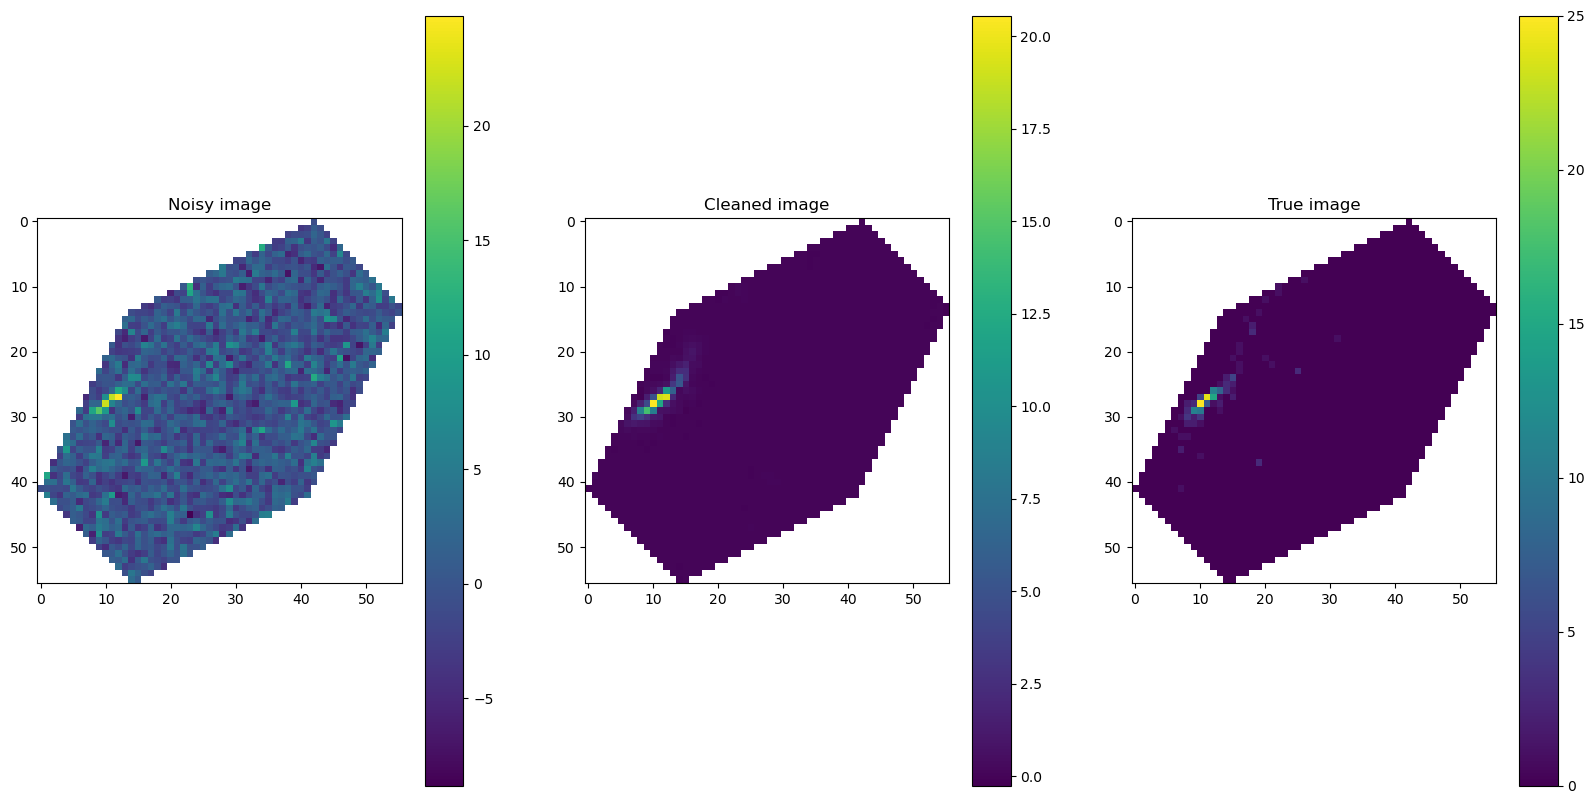

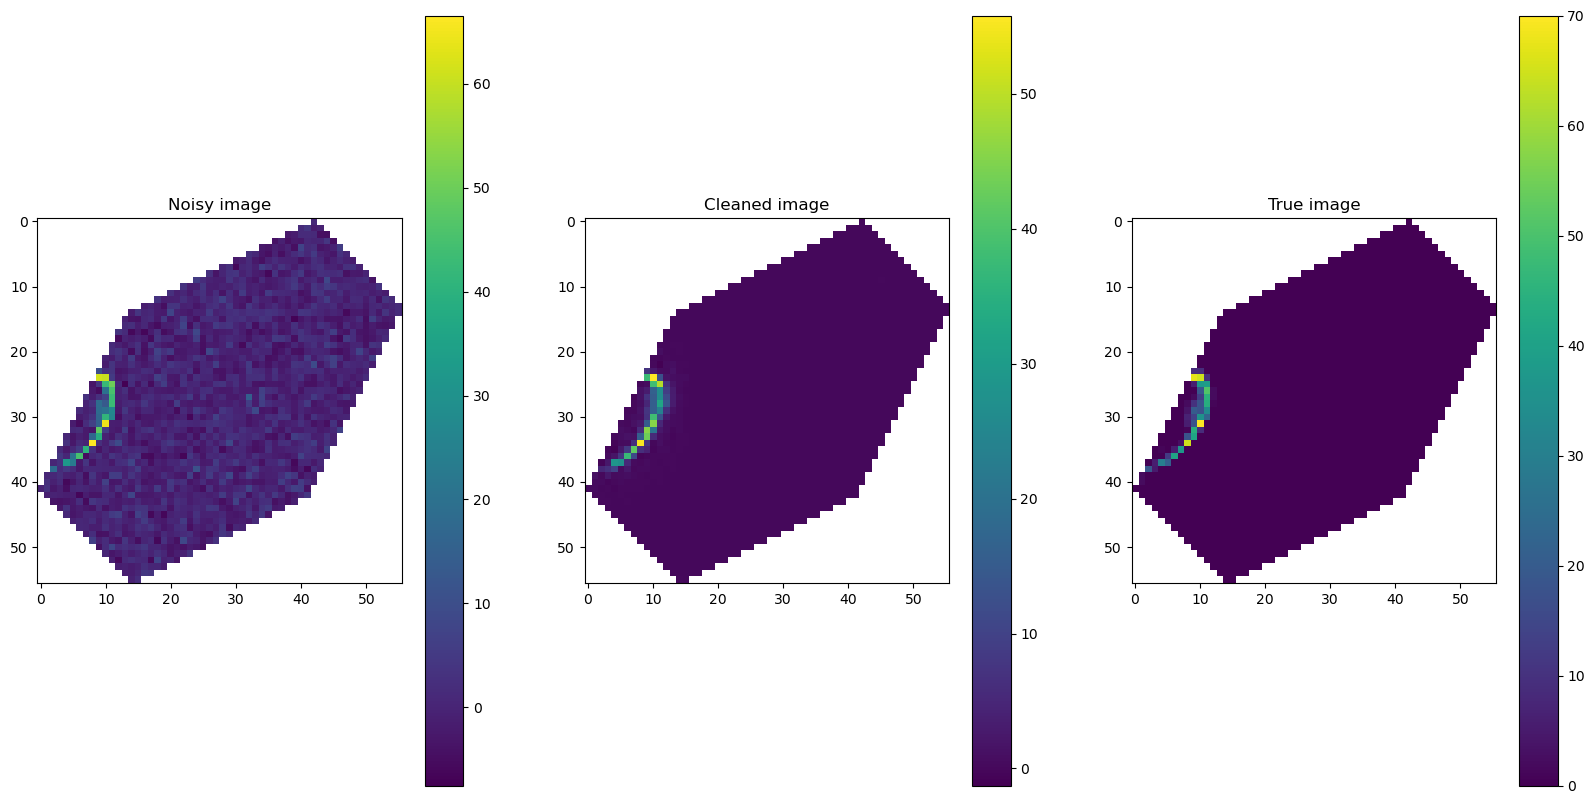

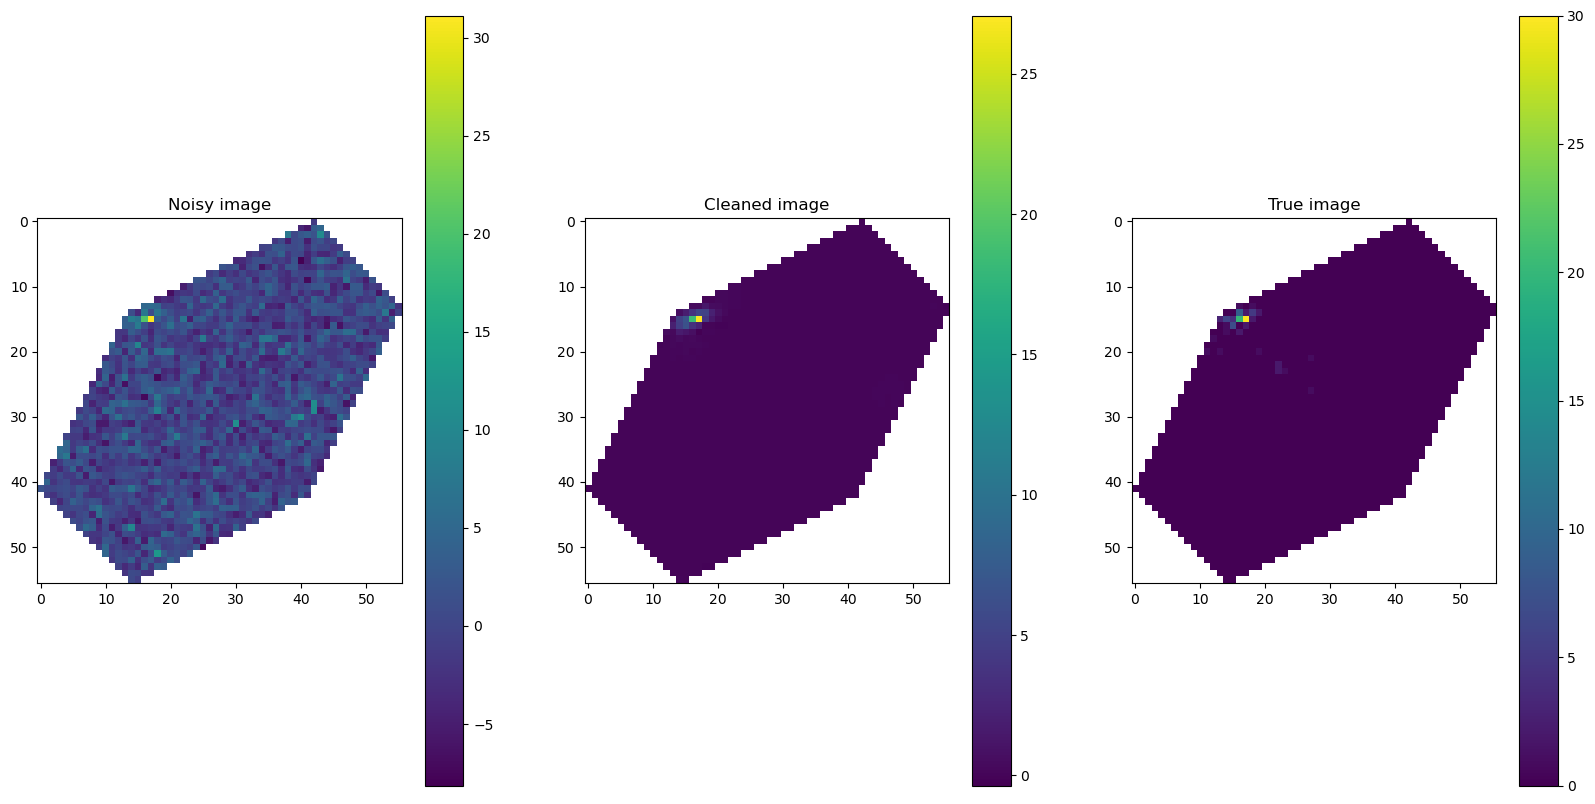

In [44]:
n_start = 3
n_im = 3

for im_i in range(n_start, n_start+n_im):
    output = network(data_noisy_test[im_i].unsqueeze(0))


    im_clean = (output.data).reshape(56, 56)
    

    im_clean = im_clean*(pix_max_noisy[idx_split:])[data_target_test==0][im_i][0][0]

    #im_clean_good[mask_clean] = data_noisy_test_im[im_i][mask_clean]
    im_clean[nan_mask] = np.nan
    
    fig, axs = plt.subplots(1,3,figsize=(20,10))

    fig_noisy = axs[0].imshow(data_noisy_test_im[im_i])#, vmin=0)
    axs[0].set_title("Noisy image")
    fig.colorbar(fig_noisy, ax=axs[0])

    fig_clean = axs[1].imshow(im_clean.detach().numpy())#, vmin=0)
    axs[1].set_title("Cleaned image")
    fig.colorbar(fig_clean, ax=axs[1])

    fig_true = axs[2].imshow(data_true_test_im[im_i])#, vmin=0)
    axs[2].set_title("True image")
    fig.colorbar(fig_true, ax=axs[2])

plt.show()    

**Training: Gamma+Proton --> Testing: Proton**

In [45]:
# Now with a minimum of 0

nan_mask = np.isnan(data_noisy[0])
data_noisy_nonan = np.nan_to_num(data_noisy)
data_true_nonan = np.nan_to_num(data_true)

# Look at the sum of all the pixels for the noisy and true images

images_noisy_sum = np.nansum(data_noisy, axis=(1,2))
images_true_sum = np.nansum(data_true, axis=(1,2))

images_high_mask = (images_noisy_sum>60)

# Look at the true images only with pixels of 0 and 1 (non-signal and signal)
# For the purpose of the classification

threshold = 0

data_true_nonan_flat = data_true_nonan.reshape((128*chunk_tot, 56*56))

# Putting them to the right form with normalization
data_noisy_arr = data_noisy[images_high_mask]
data_noisy_arr[np.nan_to_num(data_noisy_arr)<0] = 0

pix_max_noisy = np.nanmax(data_noisy_arr, axis=(1,2))[:, np.newaxis, np.newaxis]
data_noisy_norm = np.nan_to_num(data_noisy_arr/pix_max_noisy)
data_noisy_tensor = (torch.from_numpy(data_noisy_norm).float())


# Now normalize the true data in the same way as the noisy data

data_true_arr = data_true_nonan_flat[images_high_mask]
pix_max_true = np.nanmax(data_noisy_arr, axis=(1,2))[:, np.newaxis]
data_true_norm = np.nan_to_num(data_true_arr/pix_max_true)
data_true_tensor = (torch.from_numpy(data_true_norm).float())

data_noisy_tensor_im = (torch.from_numpy(data_noisy[images_high_mask])).float()

data_true_tensor_im = (torch.from_numpy(data_true[images_high_mask])).float()

# Split train and test

N, w, h = data_noisy_tensor.shape
idx_split = int(N*0.8) # 80% training, 20% testing
data_target_train = (data_target[images_high_mask])[:idx_split]
data_target_test = (data_target)[images_high_mask][idx_split:]
data_noisy_train = data_noisy_tensor[:idx_split]
data_true_train = data_true_tensor[:idx_split]
data_noisy_test = (data_noisy_tensor[idx_split:])[data_target_test==0]
data_true_test = (data_true_tensor[idx_split:])[data_target_test==0]

data_noisy_train_im = data_noisy_tensor_im[:idx_split]
data_true_train_im = data_true_tensor_im[:idx_split]
data_noisy_test_im = (data_noisy_tensor_im[idx_split:])[data_target_test==0]
data_true_test_im = (data_true_tensor_im[idx_split:])[data_target_test==0]



In [46]:
%%time

n_epochs = 50

learning_rate = 0.0001

network = AE4()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test set: Avg. loss: 0.019041
Training set: Avg. loss: 0.000531

Test set: Avg. loss: 0.000434
Training set: Avg. loss: 0.000322

Test set: Avg. loss: 0.000368
Training set: Avg. loss: 0.000286

Test set: Avg. loss: 0.000336
Training set: Avg. loss: 0.000267

Test set: Avg. loss: 0.000322
Training set: Avg. loss: 0.000254

Test set: Avg. loss: 0.000323
Training set: Avg. loss: 0.000246

Test set: Avg. loss: 0.000304
Training set: Avg. loss: 0.000239

Test set: Avg. loss: 0.000302
Training set: Avg. loss: 0.000233

Test set: Avg. loss: 0.000305
Training set: Avg. loss: 0.000229

Test set: Avg. loss: 0.000295
Training set: Avg. loss: 0.000224

Test set: Avg. loss: 0.000289
Training set: Avg. loss: 0.000220

Test set: Avg. loss: 0.000284
Training set: Avg. loss: 0.000218

Test set: Avg. loss: 0.000285
Training set: Avg. loss: 0.000215

Test set: Avg. loss: 0.000281
Training set: Avg. loss: 0.000212

Test set: Avg. loss: 0.000284
Training set: Avg. loss: 0.000209

Test set: Avg. loss: 0.0

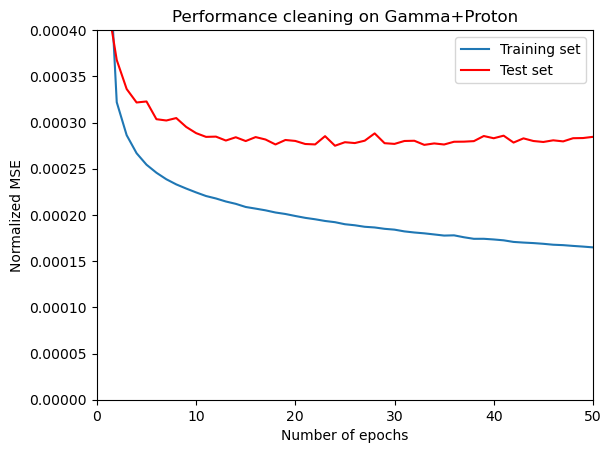

[0.0005309433922132831, 0.00032195927630509656, 0.00028629947456703287, 0.00026678483694506246, 0.00025434918184270286, 0.0002456614243330489, 0.00023859200880915377, 0.00023303922498477686, 0.00022854912165002465, 0.00022436170406394141, 0.00022045296048032496, 0.00021780066252892444, 0.0002145311566734086, 0.0002119909657561454, 0.00020859825881463105, 0.0002068197870887323, 0.0002049629349001615, 0.00020262412323824707, 0.0002010131119944981, 0.00019885196827506218, 0.00019683145327120956, 0.00019529382274546982, 0.00019345758727586275, 0.00019214072755016298, 0.00018992712978379482, 0.00018879934574424, 0.00018716114820413956, 0.00018643216171727905, 0.00018495698329664464, 0.00018406197316763059, 0.00018217501313290521, 0.0001809846144805117, 0.00018007087071212957, 0.00017887248471171755, 0.00017764879548577917, 0.00017790878672511055, 0.00017582138917754864, 0.00017413902992363624, 0.00017416559610636078, 0.00017344361430476142, 0.00017251383280554125, 0.00017077862205665587, 0.

In [47]:
plt.figure()
plt.title("Performance cleaning on Gamma+Proton")
plt.plot(train_counter, train_losses, label='Training set')
plt.plot(test_counter, test_losses, color='red', label='Test set')
plt.ylim(0,0.0004)
plt.xlim(0,50)
plt.xlabel("Number of epochs")
plt.ylabel("Normalized MSE")
plt.legend()
plt.show()

print(train_losses)
print(test_losses)

**Compare all**

In [2]:
# These lists come from earlier in the notebook

test_losses_g_g = np.array([0.019317077325799004, 0.0003006815523049594, 0.00025663429227393465, 0.00022527160997378, 0.0002102763772950413, 0.00020111100535857154, 0.0001993169493640062, 0.00018903599868093552, 0.00018316151710245926, 0.00017821530236361701, 0.00018076673495017996, 0.00017326594424590814, 0.0001760860770531663, 0.0001723708792028834, 0.00017001701442601727, 0.00016847836035056456, 0.0001681853437726673, 0.0001696965230042432, 0.0001674975749322874, 0.00016726778681840445, 0.0001666130233596686, 0.00016459943383130844, 0.00016690974796989647, 0.00016723738300108396, 0.0001669554924215527, 0.00017125633466881, 0.00016879327338454605, 0.0001711363618702846, 0.00016638965445653586, 0.00016959621938595232, 0.00016658355687696822, 0.0001724441230033849, 0.0001696075094836724, 0.00017023935037829155, 0.00017170167178797954, 0.00017177281016248985, 0.000169694742485242, 0.00017120075362737173, 0.00017258521305962458, 0.00017200614420615916, 0.00017726565007544987, 0.00017276223782700085, 0.00017323377823610863, 0.00018282335581818287, 0.00017392121089176423, 0.00017273913456565955, 0.00017714873464328652, 0.0001716697043386147, 0.0001784579357091988, 0.0001749353309773011, 0.00017478827400692055])
test_losses_gp_g = np.array([0.04647187660819134, 0.00027147580274090735, 0.00022363108544161262, 0.0002021821362282066, 0.0001889043361132329, 0.00018733030625475922, 0.0001793782107315806, 0.00017601624066733207, 0.00017092005512825227, 0.00017063672601588088, 0.00016892512536102421, 0.00016543978119314858, 0.0001705822433060163, 0.00018155159827541205, 0.0001671078056798871, 0.00016230480762602478, 0.00016429128380942345, 0.00016280148094013552, 0.00016397519910451672, 0.00016962367591415097, 0.00017479580018138287, 0.00017690491596652393, 0.00015935414367291274, 0.00016571435759612694, 0.0001642350495624677, 0.00016318753932864638, 0.00016313585880012814, 0.0001640631590696336, 0.00016881559076703534, 0.00015922823096272334, 0.00015925307496950436, 0.0001659441517291367, 0.00016099522532562961, 0.00016645430192889697, 0.00016626099691528207, 0.0001634957898518344, 0.00016634062322229946, 0.00016418459117590602, 0.00016922198441276864, 0.0001624803452493558, 0.0001643490027107012, 0.00018123770854461615, 0.0001649895253158481, 0.00016633255652906512, 0.0001663266392820856, 0.0001638926654934554, 0.00016795788945040262, 0.00016365096018562005, 0.0001644754096805547, 0.00016482352506564708, 0.00016484996350718734])
test_losses_g_p = np.array([0.010686965175916123, 0.00047122574785840484, 0.00046403663076206587, 0.00038617896420026877, 0.00036895989659245753, 0.0003634376510426114, 0.00034336357627825636, 0.0003473236860204953, 0.0003582549061271266, 0.00033382454659846325, 0.00032756518736593715, 0.00032439207847968234, 0.00032322530774964083, 0.0003229172845336609, 0.0003329748772419499, 0.00031581514118791677, 0.0003355237788800516, 0.0003177221693389728, 0.00032069803722515315, 0.0003276897937705594, 0.00031137901760303066, 0.00031522577001270895, 0.00031994656711268737, 0.00031067290109757027, 0.00031239583732000937, 0.0003149111045669642, 0.00031353048856212556, 0.0003116459615073501, 0.00031124497264988415, 0.0003143058032483217, 0.0003262719158689355, 0.00033065457438921295, 0.00030910151098565857, 0.00032593250016707087, 0.0003333548252067469, 0.0003154142402743124, 0.00032063978207809044, 0.00031596895693424915, 0.0003160439452690964, 0.0003153277780552796, 0.0003190704525621097, 0.0003271906490427332, 0.00031321018681900457, 0.0003192946038916571, 0.00031543712785609036, 0.000329538589456002, 0.0003173729884788397, 0.0003219077666554236, 0.00032319522291402234, 0.0003259307606836219, 0.0003178991287486382])
test_losses_gp_p = np.array([0.019041020965463, 0.00043360078738651625, 0.0003676559150684046, 0.0003362548454467631, 0.00032168964837058016, 0.00032278782629057855, 0.00030359960975092986, 0.0003021993326078692, 0.00030483177207195686, 0.0002952303158632756, 0.00028852263993533914, 0.0002844652081073528, 0.00028474005229628277, 0.00028050438813280687, 0.00028405601134472885, 0.0002799432041555475, 0.00028423369520886286, 0.000281607253715959, 0.000276265426245978, 0.000281097643446579, 0.0002800673017011735, 0.0002767613440594656, 0.000276298313997893, 0.00028524106001052437, 0.000274878976694016, 0.00027868572913651574, 0.0002777688545208974, 0.00028034637680929406, 0.00028824052800549576, 0.00027763275150664575, 0.00027687103861715357, 0.0002800189241825828, 0.0002802633409232371, 0.00027582153604462903, 0.0002773725804473719, 0.0002762192584820941, 0.00027918464095023205, 0.00027929470856809154, 0.0002798635611189173, 0.0002853961031035102, 0.0002829820770318603, 0.0002857666498115327, 0.0002783099753213379, 0.0002828595095482492, 0.00027999748042076576, 0.0002789431854478502, 0.0002807427902147765, 0.00027957379827828937, 0.00028301339291789736, 0.0002831958565812746, 0.0002844983707840564])





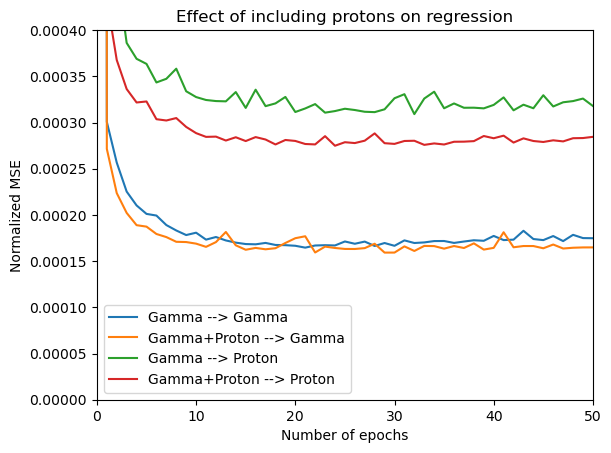

In [7]:
test_counter = np.arange(0,len(test_losses_g_g), 1)

fig_gamma_proton_reg = plt.figure()
plt.title("Effect of including protons on regression")
plt.plot(test_counter, test_losses_g_g, label='Gamma --> Gamma')
plt.plot(test_counter, test_losses_gp_g, label='Gamma+Proton --> Gamma')
plt.plot(test_counter, test_losses_g_p, label='Gamma --> Proton')
plt.plot(test_counter, test_losses_gp_p, label='Gamma+Proton --> Proton')
plt.ylim(0,0.0004)
plt.xlim(0,50)
plt.xlabel("Number of epochs")
plt.ylabel("Normalized MSE")
plt.legend()
plt.show()

fig_gamma_proton_reg.savefig("images/RegressionGammaProton.pdf")